# __Introduction to ADerrors.jl__

ADerrors is a software for linear error propagation and analysis of Monte Carlo data. The software also deals with variables with uncertainties, either correlated or uncorrelated.

Thanks to automatic differentiation techniques linear error propagation is performed exactly, even in iterative algorithm like errors in paremeters of non-linear fits and roots or integrals of functions.

__Index:__

1. Installation 
2. A calculator with uncertainties
3. Dealing with correlated data 
4. Dealing with Monte Carlo data
5. Iterative Algorithms
    1. Error propagation in fits
    2. Roots of a function
    3. Integrals of a function

## __Installation__


The ADerrors.jl package is not in the general registry, still we can use the package manager to install it directly from the git.

ADerrors.jl also depends on BDIO.jl, a software from writing/reading data in BDIO format.

To sum up,  these are the required steps in order to have a fully functional environment:

In [5]:
import Pkg
Pkg.add(url="https://gitlab.ift.uam-csic.es/alberto/bdio.jl")
Pkg.add(url="https://gitlab.ift.uam-csic.es/alberto/aderrors.jl")

    Updating git-repo `https://gitlab.ift.uam-csic.es/alberto/bdio.jl`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
    Updating git-repo `https://gitlab.ift.uam-csic.es/alberto/aderrors.jl`
   Resolving package versions...
    Updating `~/.julia/environments/v1.6/Project.toml`
  [5e92007d] ~ ADerrors v0.1.0 `https://gitlab.ift.uam-csic.es/alberto/aderrors.jl#master` ⇒ v0.1.0 `https://gitlab.ift.uam-csic.es/alberto/aderrors.jl#master`
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [5e92007d] ~ ADerrors v0.1.0 `https://gitlab.ift.uam-csic.es/alberto/aderrors.jl#master` ⇒ v0.1.0 `https://gitlab.ift.uam-csic.es/alberto/aderrors.jl#master`
Precompiling project...
  ✓ ADerrors
  ✓ juobs
2 dependencies successfully precompiled in 5 seconds (205 already precompiled)


## __A calculator with uncertainties__

The key type of the ADerrors.jl package is the uwreal data type. Generally speaking, a uwreal variable contains the value and the sources of uncertainties of a variable.

In [1]:
using ADerrors

a = uwreal([15.58, 0.34], "Data a")
b = uwreal([6.28, 0.22], "Data b")

println("Without errors")
println(a)
println(b)
uwerr(a)
uwerr(b)
println("With errors")
println(a)
println(b)

Without errors
15.58 (Error not available... maybe run uwerr)
6.28 (Error not available... maybe run uwerr)
With errors
15.58 +/- 0.34
6.28 +/- 0.22


In [2]:
c = a + b 
uwerr(c) # sqrt(err(a)^2 + err(b)^2)  data a and data b are uncorrelated
println(c)

21.86 +/- 0.4049691346263318


In [3]:
details(c)

21.86 +/- 0.4049691346263318
 ## Number of error sources: 2
 ## Number of MC ids       : 0
 ## Contribution to error  :               Ensemble  [%]     [MC length]
  #                                         Data a  70.49            -
  #                                         Data b  29.51            -


In [4]:
zero_err = sin(c) - (sin(a)*cos(b) + cos(a)*sin(b))
uwerr(zero_err)
println(zero_err) # ADerrors keeps correlations!

8.881784197001252e-16 +/- 4.496060575246783e-17


## __Dealing with correlated data__

In many situations we might have several variables with uncertainties that are not independent. These might be for example variables from previous work that we want to include in the current analysis.

The covariance between these variables is given and has to be taken into account in order to perform error propagation correctly. In Aderrors.jl this is achieved by the method _cobs(values, covariance, "TAG")_

In [5]:
avg = [16.26, 0.12, -0.0038]; # Central values of three quantities
Mcov = [0.478071 -0.176116 0.0135305
-0.176116 0.0696489 -0.00554431    # Covariance matrix
0.0135305 -0.00554431 0.000454180]; # between the quantities

p = cobs(avg, Mcov, "Correlated data") # Vector with the 3 quantities
uwerr.(p)
p

3-element Vector{uwreal}:
 16.26 +/- 0.6914267857119798
 0.12 +/- 0.2639107803785211
 -0.0038 +/- 0.021311499243366245

In [6]:
cov(p) # Check that we reproduce the original covariance

3×3 Matrix{Float64}:
  0.478071   -0.176116     0.0135305
 -0.176116    0.0696489   -0.00554431
  0.0135305  -0.00554431   0.00045418

In [7]:
z = p[1] + p[2] + cos(p[3]) # Correlations are propagated
uwerr(z) 
z  # Note that the error in z is smaller than the error in p[1]

17.379992780008692 +/- 0.4422087758697865

## __Dealing with Monte Carlo data__

So far we showed how ADerrors.jl deals with variables with uncertainties and their correlation. Typically in LatticeQCD simulations we have to analyze data coming from a Monte Carlo simulation. In this case several observables are measured on the same ensemble and the correlation has to be computed from the Monte Carlo history.

ADerrors.jl deals with this case by allowing uwreal variables to contain full Monte Carlo histories.

Here we will generate some correlated samples  of the uniform [-1,1] distribution:

In [8]:
nsamp = 500
eta = randn(nsamp)
x = Vector{Float64}(undef, nsamp)
x[1] = 0

for i in 2:nsamp
    x[i] = x[i-1] + 0.2*eta[i]
    if abs(x[i]) >1.0
        x[i] = x[i-1]
    end
end


In [9]:
xp2 = uwreal(x.^2, "Random walk ensemble in [-1,1]")

0.2327745854274323 (Error not available... maybe run uwerr)

In [10]:
xp4 = uwreal(x.^4, "Random walk ensemble in [-1,1]")

0.11704460665840583 (Error not available... maybe run uwerr)

In [11]:
cov([xp2, xp4])

2×2 Matrix{Float64}:
 0.000723204  0.000548573
 0.000548573  0.000405864

Crucially the ensemble tag ("Random walk ensemble in [-1,1]" in this case) is the same for
both observables. This tells ADerrors.jl that the measurements of both observables have been
performed in the same ensemble and makes it possible to determine the covariance of the data from
the Monte Carlo histories. Correlations, crucial to obtain correct error estimates of derived observables that depend on both variables xp2 xp4, are automatically taken into account.

To better see the correlation, we can plot the Monte Carlo history:

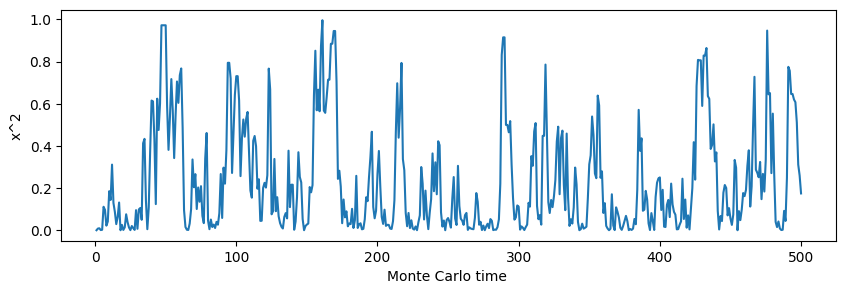

PyObject Text(24.000000000000007, 0.5, 'x^2')

In [12]:
using PyPlot
figure(figsize=(10,3))
plot(collect(1:length(x)), x.^2)
xlabel("Monte Carlo time ")
ylabel("x^2")

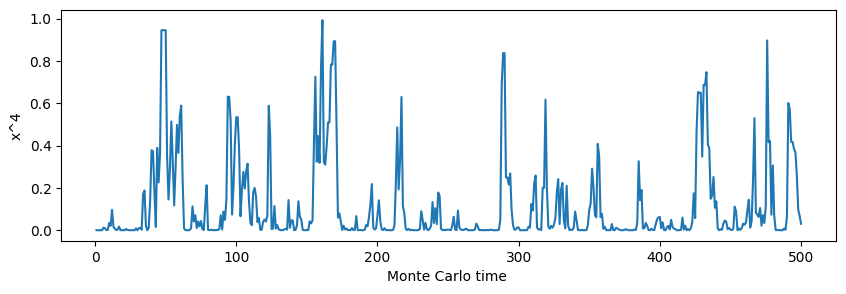

PyObject Text(24.000000000000007, 0.5, 'x^4')

In [14]:
figure(figsize=(10,3))
plot(collect(1:length(x)), x.^4)
xlabel("Monte Carlo time ")
ylabel("x^4")

Correlations are crucial to correctly estimates derived observables:

In [15]:
uwerr(xp2)
uwerr(xp4)

z = xp4 / xp2^2
uwerr(z)
println("xp2 is ", xp2)
println("xp4 is ", xp4)
println("z is ", z)

xp2 is 0.2327745854274323 +/- 0.026892446953481176
xp4 is 0.11704460665840583 +/- 0.02068140555968604
z is 2.160131961395027 +/- 0.16929567015900598


## __Iterative Algorithms__

In many pratical situations our derived observables are defined by an iterative procedure. In this case  case the derivatives needed for linear error propagation are not straigthforward to obtain. ADerrors.jl uses automatic differentiation to perform exact linear error propagation. In this way, errors can be naively propagated even in iterative algorithms. A common example is the case of fit parameters.

### __Error propagation in fits__

In general, we want to determine the values of the parameters $p_i$ that minimize the chi-square function:
$$
\chi^2(p_i; d_a) \qquad i = 1,\ldots,N_{param}, \qquad a = 1,\ldots, N_{data}
$$

where $d_a$ are the data that carry uncertainties. The latter might be correlated and we have to take this into account.

In principle ADerrors.jl could propagate the errors in the fit parameters by just propagating erorrs in each step of the minimization routine. In practice, this might be cumbersome.

A clever way to deal with this is the determination of the Hessian of the $\chi^2$ function at its minimum. In this way we can rely on external and efficient libraries to perform the minimization of the $\chi^2$ , and delegate the error propagation to the computation of the Hessian at the minimum once it is found. Such an Hessian can be computed exactly using differentiation techniques, allowing exact error propagation in fit parameters.

In this example we are going to generate some mock data and then fit them using the LeastSquaresOptim package to minimize the $\chi^2$ and the ADerrors.fit_error method to propagate the errors to the fit parameters. 


In [16]:
Pkg.add("Distributions")
Pkg.add("LeastSquaresOptim")

LoadError: UndefVarError: Pkg not defined

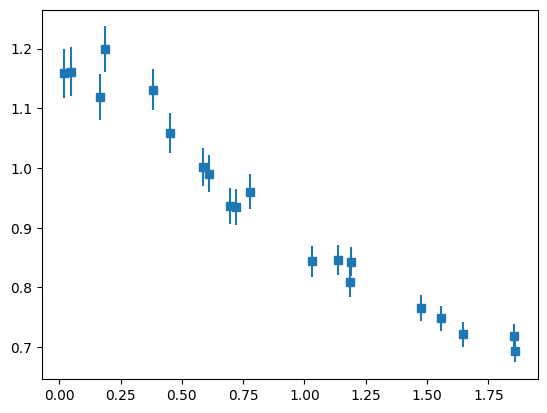

(PyObject <matplotlib.lines.Line2D object at 0x7f8e92589df0>, (), (PyObject <matplotlib.collections.LineCollection object at 0x7f8e925990d0>,))

In [17]:
using ADerrors, Distributions, LeastSquaresOptim, Printf # hide
# First generate the data:
# - We use 20 points
# - The model is 1.2*exp(-x*0.3)
# - The error in point (x,y) is 0.05/(x+y)
npt = 20
x = 2.0*rand(npt)
@. model(x) = 1.2*exp(-x*0.3) # the @ notation tells julia to apply the function to each element of the array x
dy = 0.05 ./ (x .+ model(x))
y = model(x) + dy .* randn(npt)

# Now the data x[:], y[:], dy[:] is input
# in ADerrors format:
uwy = Vector{uwreal}(undef, npt)
for i in 1:npt
xfmt = @sprintf("%6.4f",x[i])
uwy[i] = uwreal([y[i], dy[i]], "Data for point at x="*string(xfmt))
end
uwerr.(uwy);

# Show data:
errorbar(x, value.(uwy), err.(uwy), fmt="s")

Now that we have the data we can proceed with the fit.

First we define a model function the way as LeastSquaresOptim likes it.

We define a routine that returns the residuals and the chisq for some values of the x-coordinates and errors in y:


In [18]:
function fit_definitions(x, dy)
    # lmfit returns a vector. The sum of the squares is minimized
    # by LeastSquaresOptim. These are basically the residuals
    function lmfit(prm, y)
        res = Vector{eltype(prm)}(undef,length(y))
        for i in 1:length(y)
            res[i] = (y[i] - prm[1]*exp(prm[2]*x[i])) / dy[i]
        end
        return res
    end
    
# This is the usual chi^2 = sum of square of residuals
    chisq(prm,data) = sum(lmfit(prm, data) .^ 2)
    return lmfit, chisq
end
# Now get our lmfit and chi^2 functions given our values of x
# and our data in uwerr format uwy
lm, csq = fit_definitions(x, err.(uwy))

(var"#lmfit#1"{Vector{Float64}, Vector{Float64}}([0.6091065675291047, 0.4501495747371149, 1.860002271987486, 1.1902224454828634, 0.7192560334663063, 0.7792402806546166, 0.18828575516795487, 1.852741262950444, 1.184087341346391, 0.045860841244139916, 0.020721219140062086, 0.3831990799906482, 1.4749787886531895, 1.0317755442367202, 1.1387652799976586, 1.647009399903053, 0.5850116229507649, 0.6966509659934497, 0.16582637636521014, 1.5561923818437537], [0.031081069757268306, 0.033365327948652344, 0.01963228761391508, 0.0246318352666464, 0.029649761277530936, 0.028916929348128853, 0.03781056490422901, 0.0196768147451681, 0.024687637613803666, 0.04066812878090362, 0.041210442404728605, 0.03441436814911995, 0.022262812737550607, 0.026146206446419597, 0.025106716937091676, 0.02101589970665217, 0.03140993568589451, 0.029934207575614956, 0.03823830110575348, 0.021658564970250014]), var"#chisq#2"{var"#lmfit#1"{Vector{Float64}, Vector{Float64}}}(var"#lmfit#1"{Vector{Float64}, Vector{Float64}}([0.6

At this point we can proceed by fitting the data. We do that by using the LeastsquareOptim package.  Remember that ADerrors is agnostic about the way you fit the data!

In [19]:
fit = optimize(xx -> lm(xx, value.(uwy)), [1.0,1.0],
LevenbergMarquardt(), autodiff = :forward)
println("### Fit results (from LeastSquaresOptim)")
println(fit)
println("### ")

### Fit results (from LeastSquaresOptim)
Results of Optimization Algorithm
 * Algorithm: LevenbergMarquardt
 * Minimizer: [1.1918848435470408,-0.29691797329234637]
 * Sum of squares at Minimum: 16.956628
 * Iterations: 7
 * Convergence: true
 * |x - x'| < 1.0e-08: false
 * |f(x) - f(x')| / |f(x)| < 1.0e-08: true
 * |g(x)| < 1.0e-08: false
 * Function Calls: 8
 * Gradient Calls: 7
 * Multiplication Calls: 21

### 


And now the magic happens.. ADerrors nicely propagate the errors in the fit parameter by calling the fit_error function, which takes as input the value of the minimised chi^2, the fit parameters (fit.minimizer) and the data uwy

In [23]:
fitp, chiexp = fit_error(csq, fit.minimizer, uwy)

uwerr.(fitp)
exact = [1.2, -0.3]


println("### Error analysis from ADerrors ")
println("Fit results: chi^2 / chi^2_exp: ", fit.ssr, " / ", chiexp)

for i in 1:length(fitp)
    print("Fit Parameter "*string(i)*" (exact value "*string(exact[i])*": ")
    details(fitp[i])
    println(" ")
end

println("### ")

### Error analysis from ADerrors 
Fit results: chi^2 / chi^2_exp: 16.956628102637094 / 17.99999999999999
Fit Parameter 1 (exact value 1.2: 1.1918848435470408 +/- 0.015923142112776924
 ## Number of error sources: 20
 ## Number of MC ids       : 0
 ## Contribution to error  :               Ensemble  [%]     [MC length]
  #                     Data for point at x=0.0207  14.08            -
  #                     Data for point at x=0.0459  13.69            -
  #                     Data for point at x=0.1658  11.77            -
  #                     Data for point at x=0.1883  11.41            -
  #                     Data for point at x=0.3832   8.31            -
  #                     Data for point at x=0.4501   7.29            -
  #                     Data for point at x=0.5850   5.35            -
  #                     Data for point at x=0.6091   5.03            -
  #                     Data for point at x=1.8600   4.19            -
  #                     Data for point at 

### __Roots of a function__

In ADerrors.jl we can compute the roots of a function and propagate the error from our initial data to the root position x.

This is achieved with the root_error function. Let's see an example

In [24]:
data = Vector{uwreal}(undef, 3)
data[1] = uwreal([1.0, 0.2],   "Var A")
data[2] = uwreal([1.2, 0.023], "Var B")
data[3] = uwreal(rand(1000),   "White noise ensemble")

# Now define a function
f(x, p) = x + p[1]*x + cos(p[2]*x+p[3])

# Find its root using x0=1.0 as initial
# guess of the position of the root
x = root_error(f, 1.0, data)
uwerr(x)
println("Root: ", x)

# Check
z = f(x, data)
uwerr(z)
print("Better be zero (with zero error): ")
details(z)

Root: -0.4975862680237972 +/- 0.04699627802141507
Better be zero (with zero error): 0.0 +/- 1.2084823308834614e-19
 ## Number of error sources: 3
 ## Number of MC ids       : 1
 ## Contribution to error  :               Ensemble  [%]     [MC length]
  #                           White noise ensemble 100.00   1000
  #                                          Var A   0.00            -
  #                                          Var B   0.00            -
